In [2]:
#import statements
import geopandas as gpd
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

In [3]:
#Q1: How many counties are in Wisconsin?
counties = gpd.read_file("counties.geojson")
num_counties = len(counties)
num_counties

72

Text(0.5, 1.0, 'Population of Wisconsin Counties')

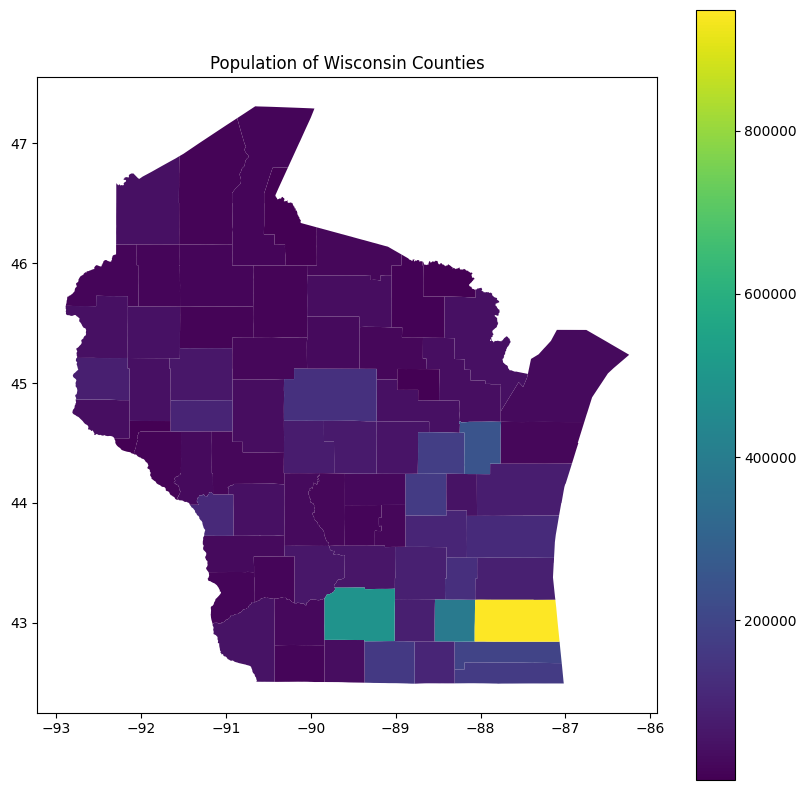

In [4]:
#Q2: What is the population of each county in WI?
ax = counties.plot(column='POP100', legend=True, figsize=(10, 10))
ax.set_title('Population of Wisconsin Counties')

In [5]:
#connect to the SQLite database
conn = sqlite3.connect('counties_tracts.db')

#load counties data from GeoJSON
counties = gpd.read_file("counties.geojson")

#read county data from the database, including area data
area_land = pd.read_sql("""SELECT * FROM counties""", conn)

#create a mapping from COUNTY codes to county names
county_code_to_name = dict(zip(area_land.COUNTY, area_land.NAME))

#map the COUNTY codes to names in area_land using the mapping dictionary
area_land['COUNTY_NAME'] = area_land['COUNTY'].map(county_code_to_name)

#merge the area data with the GeoDataFrame using the mapped names
counties = counties.merge(area_land[['COUNTY_NAME', 'AREALAND']], left_on='NAME', right_on='COUNTY_NAME', how='left')

#define your features and target variable
X = counties[['AREALAND']]
y = counties['POP100']

#splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=250)

In [6]:
#Q3: What are the counties in the test dataset?
#get county names from the original DataFrame using indices of X_test
test_county_names = counties.iloc[X_test.index]['NAME'].tolist()
test_county_names

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [7]:
#Q4: How much variance in the POP100 can a LinearRegression model explain based only on AREALAND?
#create a LinearRegression object
model = LinearRegression()
#fit the model to training data
model.fit(X_train, y_train)
#create a LinearRegression object
model = LinearRegression()
#fit model to training data
model.fit(X_train, y_train)
#calculate R^2 score
r_squared = model.score(X_test, y_test)
r_squared

0.016720430179409274

In [8]:
#Q5: What is the predicted population of a county with 600 square miles of area, according to the model?
#area in square meters
area_in_square_meters = 600 * 2.59 * 1e6

#create a DataFrame with correct column name for prediction
area_df = pd.DataFrame({'AREALAND': [area_in_square_meters]})

#predict population using the DataFrame
predicted_population = model.predict(area_df)

#output predicted population as a float
predicted_population_float = float(predicted_population[0])
predicted_population_float

78504.52061277494

In [9]:
#SQL query to get total housing units per county
housing_query = """
SELECT SUM(tracts.HU100) AS HU100, counties.NAME
FROM tracts
LEFT JOIN counties ON tracts.COUNTY = counties.COUNTY
GROUP BY counties.NAME
ORDER BY counties.NAME;
"""
housing_data = pd.read_sql(housing_query, conn)

#merge housing units data with counties GeoDataFrame
counties = counties.merge(housing_data, on='NAME', how='left')

#define your features and target variable with new 'HU100' column
X = counties[['AREALAND', 'HU100']]
y = counties['POP100']

#splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=250)

In [10]:
#Q6: What are the counties in the test dataset?
test_county_names = counties.iloc[X_test.index]['NAME'].tolist()
test_county_names

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [11]:
#Q7: What are the HU100 values for the counties in the test dataset?
#extracting HU100 values for counties in the test dataset
test_county_hu100 = counties.iloc[X_test.index][['NAME', 'HU100']].set_index('NAME')['HU100'].to_dict()
test_county_hu100

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [12]:
#Q8: How much variance in POP100 can a LinearRegression model explain based only on HU100?
X_train, X_test, y_train, y_test  # same splits used in Q3

# Define the feature and target variables using the train set
X_train = X_train[['HU100']]  # Features - only HU100
y_train = y_train  # Target variable

# Initialize the Linear Regression model
model = LinearRegression()

# Perform cross-validation on the train set and calculate the mean of the scores
scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
average_r2_score = scores.mean()
average_r2_score

0.9739348181232653

In [13]:
#Q9: What is the standard deviation of the cross validation scores from Q8?
X_train, y_train

#define Linear Regression model
model = LinearRegression()

#perform cv on train set and calculate scores
scores = cross_val_score(model, X_train[['HU100']], y_train, scoring='r2', cv=5)

#calculate sd of scores
std_deviation = np.std(scores)
std_deviation

0.01693954236334351

In [14]:
#Q10: What is the formula relating POP100 and HU100?
#fit model to training dataset
model.fit(X_train[['HU100']], y_train)

#extract coefficient and intercept
coefficient = model.coef_[0]
intercept = model.intercept_

#round coefficient and intercept to 2 decimal places
coefficient = round(coefficient, 2)
intercept = round(intercept, 2)

formula = f"POP100 = {coefficient}*HU100 + {intercept}"
formula

'POP100 = 2.47*HU100 + -9276.89'

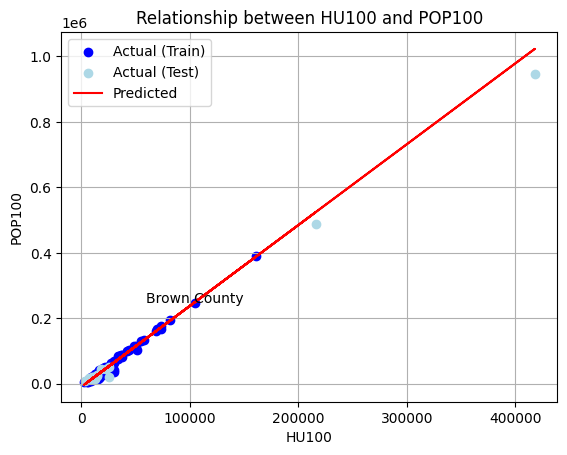

In [15]:
#Q11: What is the relationship between HU100 and POP100, visually?
#predict POP100 values for entire dataset
predicted_POP100 = model.predict(counties[['HU100']])

plt.scatter(X_train['HU100'], y_train, color='blue', label='Actual (Train)')
plt.scatter(X_test['HU100'], y_test, color='lightblue', label='Actual (Test)')

#predicted fit line
plt.plot(counties['HU100'], predicted_POP100, color='red', label='Predicted')

#amnotate Brown County
brown_county_index = counties[counties['NAME'] == 'Brown County'].index[0]
plt.text(counties.loc[brown_county_index, 'HU100'], counties.loc[brown_county_index, 'POP100'], 'Brown County', fontsize=10, ha='center')

plt.legend()

plt.xlabel('HU100')
plt.ylabel('POP100')
plt.title('Relationship between HU100 and POP100')

plt.grid(True)
plt.show()

In [16]:
#Q12: How many numbers in matrix A are between 3 and 6 (inclusive)?
#define matrix A
A = np.array([
    [0, 0, 5, 8, 4],
    [1, 2, 4, 0, 3],
    [2, 4, 0, 9, 2],
    [3, 5, 2, 1, 1],
    [0, 5, 0, 1, 0]
])

#create boolean mask for numbers between 3 and 6 (inclusive)
mask = (A >= 3) & (A <= 6)

#count number of True values in mask
count_between_3_and_6 = np.sum(mask)
count_between_3_and_6

8

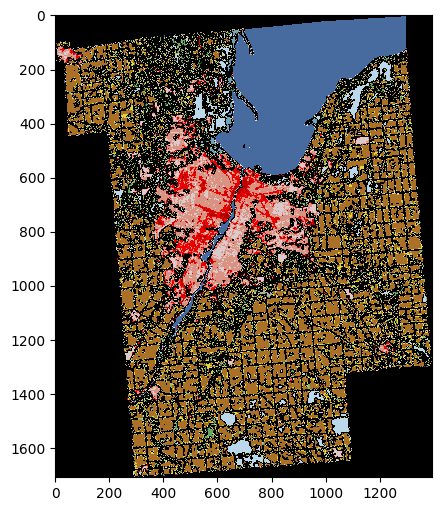

In [17]:
#Q13: How does Brown County look?
from matplotlib.colors import ListedColormap
from rasterio.mask import mask

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

land = rasterio.open("zip://land.zip")
brown_county_geometry = counties[counties['NAME'] == 'Brown County']['geometry'].to_crs(land.crs).unary_union
                                     
matrix, _ = mask(land, [brown_county_geometry], crop=True)
matrix = matrix[0]

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap)


In [18]:
#Q14: What portion of Brown County is "Open Water"?
#define numeric code for "Open Water"
open_water_code = 11

#count number of cells with value corresponding to "Open Water"
open_water_cells = np.count_nonzero(matrix == open_water_code)

#calculate total number of non-zero cells
total_cells_brown_county = np.count_nonzero(matrix)

#calculate portion that is "Open Water"
portion_open_water = open_water_cells / total_cells_brown_county
portion_open_water

0.13797526789725206

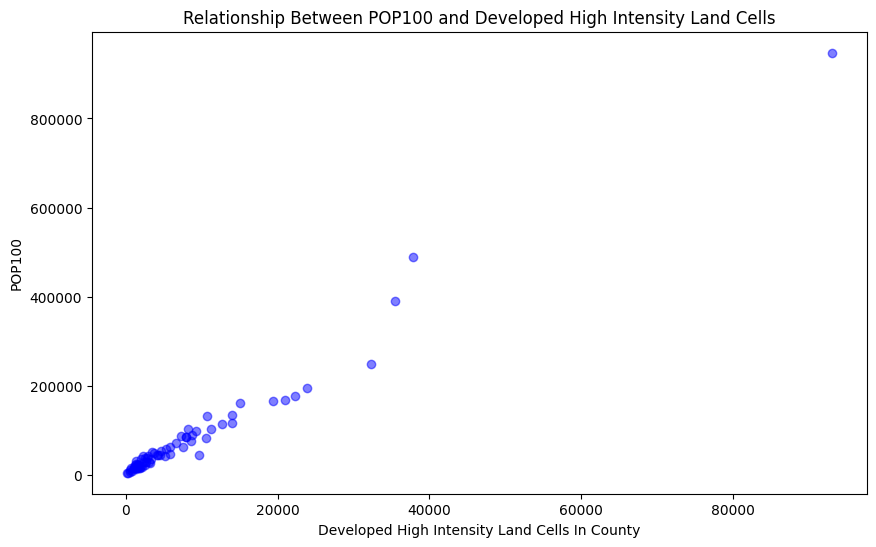

In [19]:
#Q15: What is the Relationship Between POP100 and Developed High Intensity Land Cells?
#developed High Intensity classification code
developed_land_code = 24 

#open land use raster data
land = rasterio.open("zip://land.zip")

#initialize a column for developed land cell count
counties['DEVELOPED_LAND_CELLS'] = 0

#'counties' GeoDataFrame has same coordinate reference system as land raster
counties_crs = counties.to_crs(land.crs)

#loop through each county, mask raster with county's geometry, count developed land cells
for index, county in counties_crs.iterrows():
    #get county geometry
    county_geometry = county['geometry']

    #create a mask for raster with county geometry
    masked_land_matrix, _ = mask(land, [county_geometry], crop=True)
    masked_land_matrix = masked_land_matrix[0]

    #count cells of developed land type
    developed_land_cells = np.count_nonzero(masked_land_matrix == developed_land_code)

    #add count to 'DEVELOPED_LAND_CELLS' column in original counties GeoDataFrame
    counties.loc[index, 'DEVELOPED_LAND_CELLS'] = developed_land_cells

plt.figure(figsize=(10, 6))
plt.scatter(counties['DEVELOPED_LAND_CELLS'], counties['POP100'], c='blue', alpha=0.5)
plt.title('Relationship Between POP100 and Developed High Intensity Land Cells')
plt.xlabel('Developed High Intensity Land Cells In County')
plt.ylabel('POP100')
plt.show()


In [20]:
#define land use codes and descriptions
land_use = {
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land (Rock/Sand/Clay)',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

#load census tract shapefile into a GeoDataFrame
tracts = gpd.read_file('tracts.shp')

#open land use raster data
land = rasterio.open("zip://land.zip")

#reproject vector data to match the CRS of raster data
tracts = tracts.to_crs(land.crs)

#initialize columns for land use counts
for code in land_use:
    tracts[f'land_{code}_cells'] = 0

for index, tract in tracts.iterrows():
    #perform masking operation
    tract_geometry = tract['geometry']
    masked_land_matrix, _ = mask(land, [tract_geometry], crop=True)
    masked_land_matrix = masked_land_matrix[0]

    #count cells for each land use type
    for code in land_use:
        tracts.loc[index, f'land_{code}_cells'] = np.count_nonzero(masked_land_matrix == code)

#split into train and test sets
X = tracts[[f'land_{code}_cells' for code in land_use]]  # Features
y = tracts['POP100']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=300)

#builf regression model
model = LinearRegression()
model.fit(X_train, y_train)

comment = """ 
The bar plot visualizes the coefficients of each land use feature from our linear regression model, which reflects their relative importance in predicting the population (POP100). Positive values suggest a positive relationship with population, while negative values suggest a negative relationship. For example, 'Developed, Medium Intensity' areas have the most positive association with population, indicating that as the number of cells of medium intensity developed land increases, so does the population. Conversely, 'Developed, High Intensity' areas show a negative association, which may reflect limitations in how development intensity relates to population density or perhaps indicate urban centers where population growth is less rapid. When building my model in Part 2, I could focus on features with higher absolute coefficient values as they appear to have a more significant impact on the population, or I could explore transforming features to better capture their relationship with population, possibly through polynomial features or interaction terms. 
"""
print(comment)

 
The bar plot visualizes the coefficients of each land use feature from our linear regression model, which reflects their relative importance in predicting the population (POP100). Positive values suggest a positive relationship with population, while negative values suggest a negative relationship. For example, 'Developed, Medium Intensity' areas have the most positive association with population, indicating that as the number of cells of medium intensity developed land increases, so does the population. Conversely, 'Developed, High Intensity' areas show a negative association, which may reflect limitations in how development intensity relates to population density or perhaps indicate urban centers where population growth is less rapid. When building my model in Part 2, I could focus on features with higher absolute coefficient values as they appear to have a more significant impact on the population, or I could explore transforming features to better capture their relationship with 

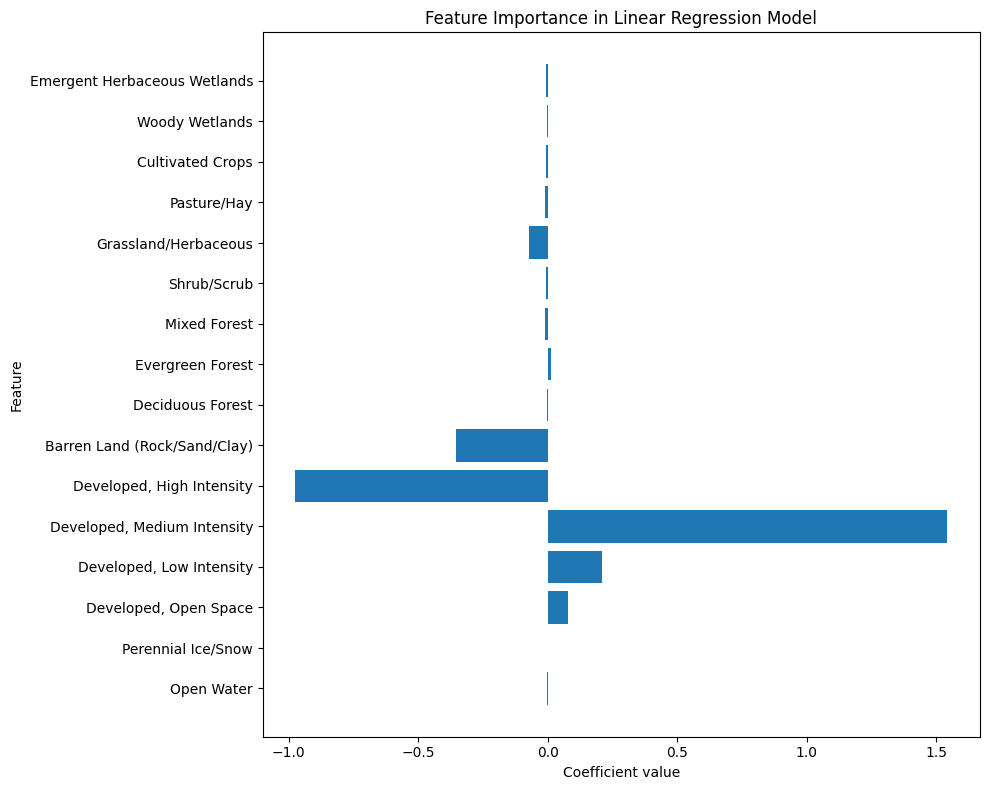

In [21]:
#Q16: What features does your model rely on most?
#get coefficients from the model
coefs = model.coef_

#map feature names to the actual land use descriptions
features = [land_use[int(code.split('_')[1])] for code in X.columns]

#create a bar plot with mapped feature names
plt.figure(figsize=(10, 8))
plt.barh(features, coefs)
plt.xlabel('Coefficient value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression Model')
plt.tight_layout()
plt.show()

#The bar plot indicates which features the model relies on most when predicting population. Notably, 'Developed, Medium Intensity' land appears to be the most significant positive predictor of population, which makes sense as these areas typically include residential and mixed-use urban areas that are densely populated. On the other hand, 'Developed, High Intensity' land has a notable negative impact, potentially due to the nature of high-intensity urban areas that might be more commercial or industrial, where fewer people reside. This insight into feature importance is crucial for my model, as it helps me understand which types of land use are most indicative of higher or lower population counts. In model refinement, I could choose to investigate these relationships further or even look into the possibility of nonlinear relationships or interactions between features.

In [22]:
#model 1
model_1_features = ['land_41_cells', 'land_42_cells', 'land_22_cells', 'land_24_cells']
model_1 = LinearRegression()

#model 2
model_2_features = ['land_21_cells', 'land_22_cells', 'land_23_cells']
pipeline_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

#perform 5-fold cv for both models
cv_scores_1 = cross_val_score(model_1, X_train[model_1_features], y_train, cv=5)
cv_scores_2 = cross_val_score(pipeline_2, X_train[model_2_features], y_train, cv=5)

#calculate mean and variance of CV scores
cv_mean_1, cv_variance_1 = cv_scores_1.mean(), cv_scores_1.var()
cv_mean_2, cv_variance_2 = cv_scores_2.mean(), cv_scores_2.var()

print(f"Model 1 CV Mean: {cv_mean_1}, Variance: {cv_variance_1}")
print(f"Model 2 CV Mean: {cv_mean_2}, Variance: {cv_variance_2}")

#comment on the recommended model based on CV results
comment = """
Based on cross-validation results, Model 2 is recommended. The chosen model has a higher mean cross-validation score, indicating better generalization performance. Additionally, it has a lower variance in cross-validation scores, suggesting that the model's performance is more stable across different subsets of the data. Considerations for model simplicity and other factors such as interpretability, computational efficiency, and domain-specific considerations were also taken into account in making this recommendation. For example, Model 2 has less features than Model 1.
"""
print(comment)


Model 1 CV Mean: 0.26728158211709874, Variance: 0.0031986172456170666
Model 2 CV Mean: 0.4030454972981232, Variance: 0.0026365304238969425

Based on cross-validation results, Model 2 is recommended. The chosen model has a higher mean cross-validation score, indicating better generalization performance. Additionally, it has a lower variance in cross-validation scores, suggesting that the model's performance is more stable across different subsets of the data. Considerations for model simplicity and other factors such as interpretability, computational efficiency, and domain-specific considerations were also taken into account in making this recommendation. For example, Model 2 has less features than Model 1.



In [23]:
#Q17: How does your recommended model score against the test dataset?
#evaluate and compare models based on their cv scores
mean_cv_score_model1 = cv_scores_1.mean()
variance_cv_score_model1 = cv_variance_1.var()

mean_cv_score_model2 = cv_scores_2.mean()
variance_cv_score_model2 = cv_variance_2.var()

#use model with higher mean CV score and lower variance
if mean_cv_score_model1 > mean_cv_score_model2 and variance_cv_score_model1 < variance_cv_score_model2:
    recommended_model = model_1
    recommended_features = model_1_features
else:
    recommended_model = pipeline_2
    recommended_features = model_2_features

#fit recommended model to entire training dataset
recommended_model.fit(X_train[recommended_features], y_train)

#fit recommended model to entire training dataset
recommended_model = pipeline_2.fit(X_train, y_train)

#score model against test dataset
test_score = explained_variance_score(y_test, recommended_model.predict(X_test))
test_score

#the recommended model achieved an explained variance score of 0.49089379226712515, which is above the threshold of 0.35 required for this task. This score indicates that the model explains a significant amount of the variance in the test dataset, which is indicative of its predictive performance and suitability for deployment in a real-world setting.

0.49089379226712515